# 1| load data


In [2]:
import pandas as pd
df = pd.read_csv('Phishing_Email.csv')
df = df.drop(columns=['Unnamed: 0'])
print(df.shape)
print(df['Email Type'].value_counts())
df.head()


(18650, 2)
Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


# 2| data preprocessing

In [37]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop = set(stopwords.words('english'))

def clean_text(t: str) -> str:
    """最快速的簡化版文字清洗，只用 NLTK 斷詞，不做 lemmatization。"""
    if not isinstance(t, str):                 # 防禦 NaN
        t = ''
    t = t.lower()
    t = re.sub(r'<.*?>', ' ', t)               # 去 HTML
    t = re.sub(r'http\S+|www\.\S+', ' ', t)    # 去網址
    t = re.sub(r'[^a-z\s]', ' ', t)            # 去標點與數字
    tokens = [w for w in word_tokenize(t) if w not in stop]
    return ' '.join(tokens)

# 先把 Email Text 轉成可靠字串，避免 NaN 觸發 AttributeError
df['Email Text'] = df['Email Text'].fillna('').astype(str)

# 實際執行清洗與標籤映射
df['text_clean'] = df['Email Text'].apply(clean_text)
df['label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

# 確認成果
print(df[['text_clean', 'label']].head())


                                          text_clean  label
0  disc uniformitarianism sex lang dick hudson ob...      0
1  side galicismos galicismo spanish term names i...      0
2  equistar deal tickets still available assist r...      0
3  hello hot lil horny toy one dream open minded ...      1
4  software incredibly low prices lower drapery s...      1


# 3 Classical Baselines

In [ ]:
# 3-1 classical baselines
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_train, y_train = train_df['Email Text'], train_df['label']
X_val,   y_val   = val_df['Email Text'],   val_df['label']
X_test,  y_test  = test_df['Email Text'],  test_df['label']

def build_model(clf):
    return Pipeline([
        ("tfidf", TfidfVectorizer(max_df=0.9, ngram_range=(1,2), stop_words="english")),
        ("clf",   clf)
    ])

models = {
    "LogReg": build_model(LogisticRegression(max_iter=1000)),
    "SVM":    build_model(LinearSVC()),
    "NB":     build_model(MultinomialNB())
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    prob  = mdl.decision_function(X_test) if hasattr(mdl, "decision_function") else mdl.predict_proba(X_test)[:,1]
    auc   = roc_auc_score(y_test, prob)
    rpt   = classification_report(y_test, preds, output_dict=True, zero_division=0)
    results[name] = {"auc": auc, "report": rpt, "preds": preds}

print({k:v["auc"] for k,v in results.items()})


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



{'LogReg': 0.9958415485998294, 'SVM': 0.997495046736631, 'NB': 0.9960560694951287}


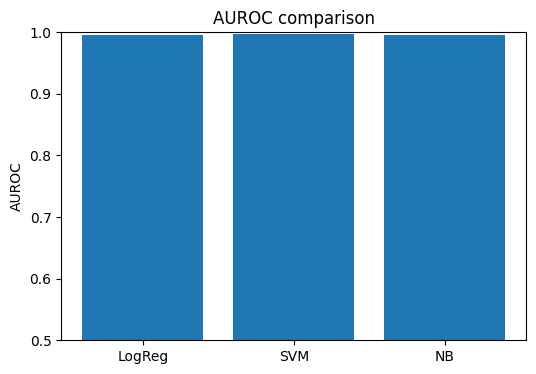

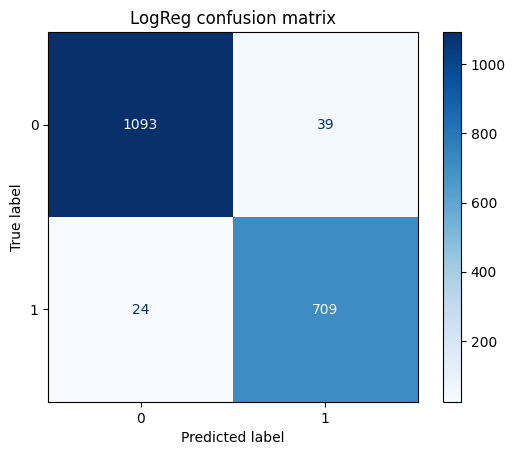

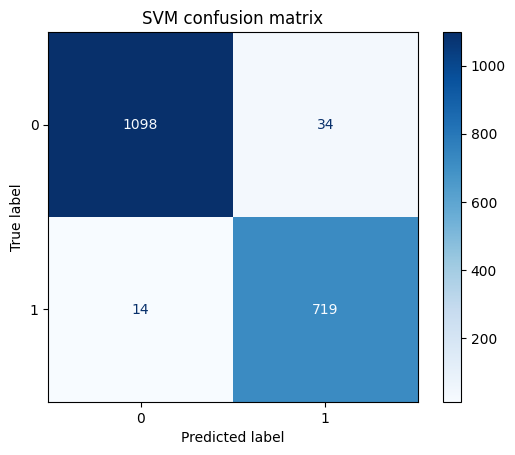

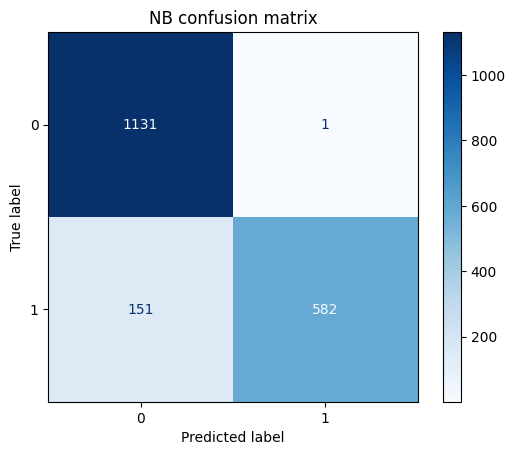

<Figure size 600x600 with 0 Axes>

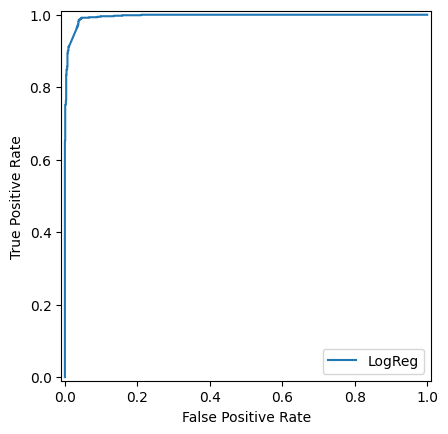

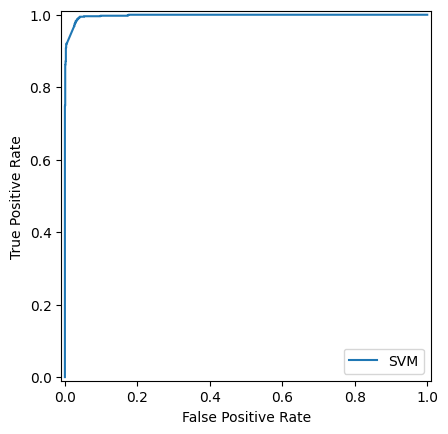

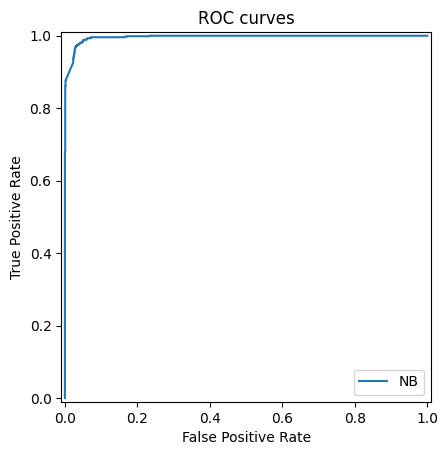

In [ ]:
# 3-2 visualization
from sklearn.metrics import roc_curve, RocCurveDisplay

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(results.keys(), [v["auc"] for v in results.values()])
ax.set_ylim(0.5,1.0)
ax.set_title("AUROC comparison")
ax.set_ylabel("AUROC")
plt.show()

for name, info in results.items():
    ConfusionMatrixDisplay.from_predictions(y_test, info["preds"], cmap="Blues")
    plt.title(f"{name} confusion matrix")
    plt.show()

plt.figure(figsize=(6,6))
for name, info in results.items():
    if name == "NB":              # Naive Bayes already provides prob
        score = models["NB"].predict_proba(X_test)[:,1]
    elif name in ["LogReg", "SVM"]:
        score = models[name].decision_function(X_test)
    else:
        score = bert_logits[:,1]
    fpr, tpr, _ = roc_curve(y_test, score)
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=name).plot()
plt.title("ROC curves")
plt.show()


# 4 切分資料集並準備 tokenizer：

In [ ]:
from sklearn.model_selection import train_test_split
# 分割資料集，80% 訓練，10% 驗證，10% 測試
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=87, stratify=df['label'])
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=87, stratify=temp_df['label'])

import tensorflow as tf
from tensorflow.keras import layers, models

max_tokens = 30000     # 字典大小
max_len    = 120       # 句子截斷長度

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len
)
vectorizer.adapt(train_df['text_clean'].values)

def make_ds(df, batch=32, shuffle=False):
    x = df['text_clean'].values
    y = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle: ds = ds.shuffle(len(df), seed=87)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds.map(lambda text, label: (vectorizer(text), label))

train_ds = make_ds(train_df, shuffle=True)
val_ds   = make_ds(val_df)
test_ds  = make_ds(test_df)

model = models.Sequential([
    layers.Embedding(max_tokens, 128, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(train_ds,
                    epochs=6,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/6
467/467 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.8747 - auc: 0.9339 - loss: 0.2664 - val_accuracy: 0.9780 - val_auc: 0.9968 - val_loss: 0.0641
Epoch 2/6
467/467 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9854 - auc: 0.9989 - loss: 0.0337 - val_accuracy: 0.9764 - val_auc: 0.9947 - val_loss: 0.0825
Epoch 3/6
467/467 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.9883 - auc: 0.9995 - loss: 0.0228 - val_accuracy: 0.9684 - val_auc: 0.9941 - val_loss: 0.0892


In [54]:
loss, acc, auc = model.evaluate(test_ds)
print(f"測試集 — Accuracy {acc:.4f} | AUC {auc:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9721 - auc: 0.9979 - loss: 0.0623
測試集 — Accuracy 0.9678 | AUC 0.9971


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


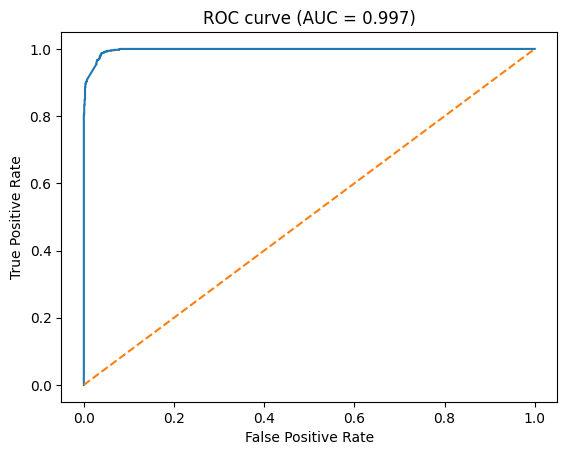

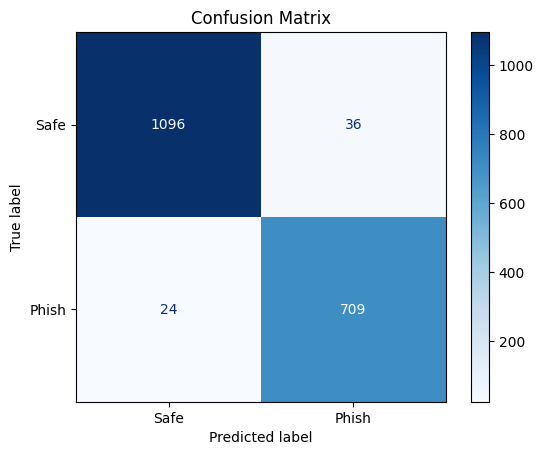

In [61]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

# 取測試集預測機率
proba = model.predict(test_ds).ravel()
y_true = test_df['label'].values

# ROC 曲線
fpr, tpr, _ = roc_curve(y_true, proba)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {auc(fpr,tpr):.3f})')
plt.savefig('roc_lstm.png', dpi=300)

# 混淆矩陣
y_pred = (proba > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Safe','Phish']).plot(cmap='Blues')
plt.title('Confusion Matrix'); plt.savefig('cm_lstm.png', dpi=300)


# 5 畫圖

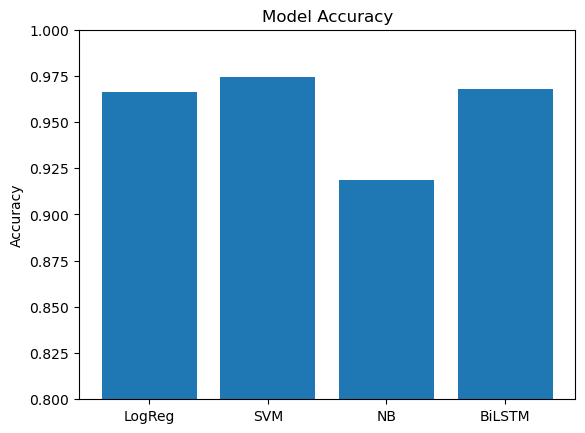

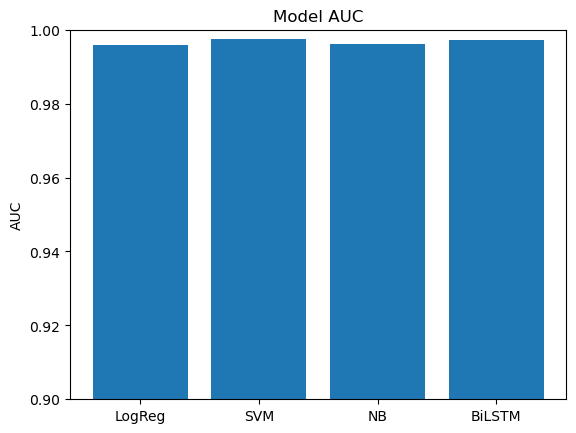

In [1]:
import matplotlib.pyplot as plt

# Metrics gathered from confusion matrices and previous AUC calculations
models = ["LogReg", "SVM", "NB", "BiLSTM"]
accuracy = {
    "LogReg": (1093 + 709) / (1093 + 39 + 24 + 709),
    "SVM": (1098 + 719) / (1098 + 34 + 14 + 719),
    "NB": (1131 + 582) / (1131 + 1 + 151 + 582),
    "BiLSTM": (1096 + 709) / (1096 + 36 + 24 + 709),
}
auc = {
    "LogReg": 0.9958415485998294,
    "SVM": 0.997495046736631,
    "NB": 0.9960560694951287,
    "BiLSTM": 0.9971,  # from earlier evaluation printout
}

# Accuracy plot
plt.figure()
plt.bar(models, [accuracy[m] for m in models])
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

# AUC plot
plt.figure()
plt.bar(models, [auc[m] for m in models])
plt.ylim(0.9, 1.0)
plt.ylabel("AUC")
plt.title("Model AUC")
plt.show()
